In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy

import warnings
warnings.filterwarnings("ignore")

sc.settings.verbosity = 0

In [2]:
try:
    from sys import path as syspath
    from os import path as ospath
    syspath.append(ospath.join(ospath.expanduser("~"), './'))
    
    from main import *
    import dNN
    import visualization as vis
except ImportError:
    print('Module not found')

In [3]:
ada = sc.read_h5ad("data/heart_global_processed_v3.h5ad") #after QC, downsample and HVG
ada

AnnData object with n_obs × n_vars = 9199 × 3000
    obs: 'cell_type', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'ident_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1p', 'raw'
    obsp: 'connectivities', 'distances'

In [4]:
ada.raw.X.shape
#del ada.raw

(9199, 33538)

In [5]:
ada.obs['ident'].value_counts()

EC             1245
NK              911
CD8+T_cytox     896
LYVE1+MA1       762
CD16+Mo         690
CD8+T_tem       650
FB              470
DOCK4+MA1       452
LYVE1+MA3       397
CD4+T_cytox     382
DOCK4+MA2       377
MA_mod          273
Mast            250
NKT             248
B_cells         231
Mo_pi           213
CD4+T_tem       207
LYVE1+MA2       204
MA_AgP          182
DC              155
IL17RA+Mo         4
Name: ident, dtype: int64

In [6]:
# import numpy.core.defchararray as np_f

# ada.obs['ident'] = np_f.replace(np.asarray(ada.obs['cell_states'], dtype=str), 'Ø', 'A')
# ada.obs['ident'] = ada.obs['ident'].astype('category')
# ada.obs['ident'].value_counts()

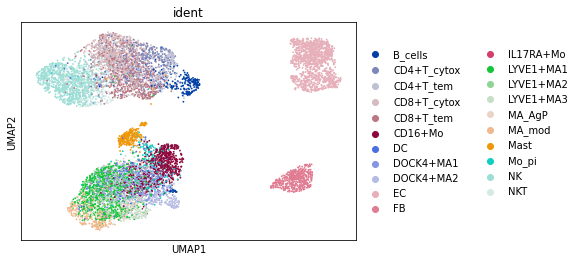

In [6]:
sc.pl.umap(ada, color='ident')

## create a Xct_metrics obj:

In [8]:
heart = Xct_metrics(ada)
type(heart)

main.Xct_metrics

In [9]:
heart.DB.head()

,ligand,receptor
0,BDNF,TRPC1
1,CXCL12,GNAI2
2,PF4,GNAI2
3,EPOR,TRPC3
4,EPOR,EPO


In [10]:
heart._genes_index_DB

array([[1188,    0],
       [2209, 2074],
       [2502, 2074],
       ...,
       [   0,    0],
       [   0,    0],
       [   0, 1506]])

In [11]:
id1 = heart._genes_index_DB[0, 0]
ada.var_names[id1-1] #check

'BDNF'

1092 (intervals for fit) / 2865 (filtered -Inf) / 3000 (original) features for the fit


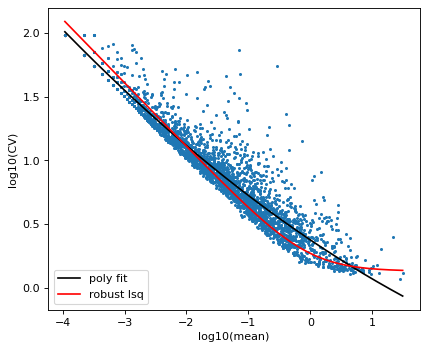

array([-0.10906608,  0.0131698 , -0.0710078 , ..., -0.05856845,
        0.8044769 ,  1.30124536])

In [12]:
heart.chen2016_fit(ada, plot = True, verbose = True)

## create a Xct obj with GRN building:

In [7]:
# obj1 = Xct(ada, 'FB', 'MA_AgP', build_GRN = True, save_GRN = True, 
#           pcNet_name = 'Net_FB2MA_AgP', mode = 'full', verbose=True)
obj1 = Xct(ada, 'FB', 'MA_AgP', build_GRN = False, 
           pcNet_name = 'Net_FB2MA_AgP', mode = 'full', verbose=True)
print(obj1)

init an Xct object for interactions from FB (470) to MA_AgP (182)...
loading GRNs...
building correspondence...
init completed.
Xct object for interactions from FB (470) to MA_AgP (182)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [8]:
df1 = obj1.fill_metric()
len(df1)

771

In [15]:
#df1[df1.ligand == 'MIF'] 

## mode 'full':

In [9]:
obj1._net_A.shape, obj1._net_B.shape, obj1._w.shape #check

((3000, 3000), (3000, 3000), (6000, 6000))

In [10]:
w12 = obj1._w[:obj1._net_A.shape[0], obj1._net_A.shape[1]:]

np.mean(w12) # check scale 

1.001131863452909

In [12]:
#selected LR pairs
candidates = get_candidates(df1)
print(len(candidates))
candidates[:5]

771


['CXCL12_GNAI2', 'PTPN6_EPO', 'IL1B_EPO', 'LGALS1_PTPRC', 'IL1B_PLAUR']

In [13]:
counts_np1 = get_counts_np(obj1)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape

(2, (3000, 470), (3000, 182))

In [15]:
projections, losses = dNN.train_and_project(counts_np1, w = obj1._w, dim = 2, steps = 1000, lr = 0.01)

Net(
  (linear1): Linear(in_features=470, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=30, bias=True)
  (linear3): Linear(in_features=30, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=182, out_features=76, bias=True)
  (linear2): Linear(in_features=76, out_features=19, bias=True)
  (linear3): Linear(in_features=19, out_features=2, bias=True)
)
1 6645.94091796875
100 852.3892211914062
200 838.748291015625
300 837.0460205078125
400 836.4495239257812
500 836.188720703125
600 835.9005126953125
700 836.2744140625
800 835.7067260742188
900 836.2356567382812
1000 835.6018676757812


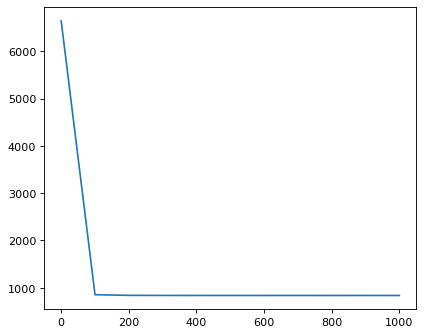

In [17]:
plot_nn_loss(losses)

In [18]:
df_nn = nn_aligned_dist(obj1, projections)
df_nn

computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...


,idx,dist,rank,correspondence_score
RPS15A_HSPA1A,"(2224, 2785)",0.000001,1,4.947121e+01
ABI3BP_RPL35,"(2367, 1611)",0.000002,2,4.870595e+01
COL5A2_RPL9,"(1767, 2086)",0.000002,3,4.793413e+01
RPS13_HLA-A,"(1709, 2358)",0.000002,4,4.514898e+01
HLA-A_RPS2,"(2358, 2262)",0.000002,5,5.712042e+01
...,...,...,...,...
TBATA_C1QTNF9,"(2302, 834)",0.032267,8999996,2.743057e-48
VSIG4_XKR4,"(2828, 2895)",0.032267,8999997,2.743057e-48
TBATA_FOXP2,"(2302, 833)",0.032267,8999998,2.743057e-48
VSIG4_CCL11,"(2828, 2887)",0.032267,8999999,2.743057e-48


[[ 1.         -0.34936287]
 [-0.34936287  1.        ]]


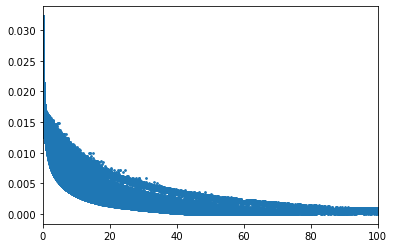

In [19]:
#check corr

select = df_nn['correspondence_score'] != 0
nX = np.asarray(df_nn['correspondence_score'][select])
nY = np.asarray(df_nn['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [20]:
df_nn_filtered = filtered_nn_aligned_dist(df_nn, candidates)
df_nn_filtered.head()

manifold aligned # of L-R pairs: 771


,idx,dist,rank,correspondence_score,rank_filtered
CTGF_ITGB2,"(2772, 2291)",0.000977,49192,33.249583,1
MIF_CD74,"(1672, 2783)",0.001184,58198,41.569532,2
COL6A3_CD44,"(2171, 2303)",0.001331,64299,32.110737,3
CYR61_ITGB2,"(2568, 2291)",0.001555,73297,22.179000,4
SERPINF1_PLXDC2,"(2719, 1687)",0.001671,77804,32.503590,5


In [21]:
df_enriched = chi2_test(df_nn, df = 3, pval = 0.05, FDR = True, candidates = candidates)

df_enriched


Total enriched: 15 / 9000000


,idx,dist,rank,correspondence_score,q_val,enriched_rank
CTGF_ITGB2,"(2772, 2291)",0.000977,49192,33.249583,0.003048,1
MIF_CD74,"(1672, 2783)",0.001184,58198,41.569532,0.004580,2
COL6A3_CD44,"(2171, 2303)",0.001331,64299,32.110737,0.005895,3
CYR61_ITGB2,"(2568, 2291)",0.001555,73297,22.179000,0.008239,4
SERPINF1_PLXDC2,"(2719, 1687)",0.001671,77804,32.503590,0.009619,5
VCAN_CD44,"(2763, 2303)",0.001873,85624,20.863390,0.012322,6
CCL2_CXCR4,"(2900, 2822)",0.001936,88153,23.124910,0.013219,7
LAMB1_CD44,"(1276, 2303)",0.001954,88845,19.726001,0.013477,8
APOE_TREM2,"(2960, 2484)",0.002290,103016,16.492022,0.018686,9
LGALS1_PTPRC,"(2461, 2557)",0.002301,103534,19.644831,0.018873,10


In [22]:
df_nn_filtered.loc['MIF_CD74']

idx                     (1672, 2783)
dist                        0.001184
rank                           58198
correspondence_score       41.569532
rank_filtered                      2
Name: MIF_CD74, dtype: object

## mode 'comb':

In [25]:
obj2 = Xct(ada, 'FB', 'MA_AgP', build_GRN = False, 
           pcNet_name = 'Net_FB2MA_AgP', mode = 'comb', verbose=True)

init an Xct object for interactions from FB (470) to MA_AgP (182)...
loading GRNs...
building correspondence...
init completed.


In [26]:
w12 = obj2._w[:obj2._net_A.shape[0], obj2._net_A.shape[1]:]

np.mean(w12) 

0.00947251522922452

Net(
  (linear1): Linear(in_features=470, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=30, bias=True)
  (linear3): Linear(in_features=30, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=182, out_features=76, bias=True)
  (linear2): Linear(in_features=76, out_features=19, bias=True)
  (linear3): Linear(in_features=19, out_features=2, bias=True)
)
0 91.311279296875
99 33.297264099121094
199 27.983638763427734
299 26.362926483154297
399 26.10501480102539
499 25.68520736694336
599 25.605079650878906
699 25.577686309814453
799 25.70964813232422
899 25.58669090270996
999 25.52915382385254


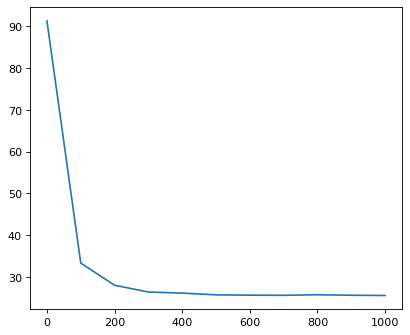

In [27]:
projections2, losses2 = obj2.nn_projection(n = 1000, plot_loss = True)

In [28]:
df_nn2 = obj2.nn_output(projections2)
df_nn2.head()

computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...


,idx,dist,rank,correspondence_score
PLA2G2A_CD74,"(2989, 2783)",0.000107,1,626.270984
DCN_CD74,"(2859, 2783)",0.001103,2,479.729454
S100A6_CD74,"(2464, 2783)",0.001446,3,440.681650
TNC_CD74,"(2986, 2783)",0.001627,4,423.831926
LUM_CD74,"(2935, 2783)",0.001887,5,400.965266


[[ 1.         -0.43556441]
 [-0.43556441  1.        ]]


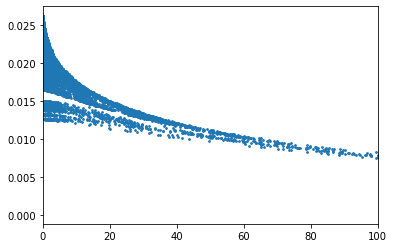

In [29]:
#check corr
select = df_nn2['correspondence_score'] != 0
nX = np.asarray(df_nn2['correspondence_score'][select])
nY = np.asarray(df_nn2['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [30]:
df_nn_filtered2 = obj2.filtered_nn_output(df_nn2, candidates)
df_nn_filtered2.head()

manifold aligned # of L-R pairs: 771


,idx,dist,rank,correspondence_score,rank_filtered
SERPINF1_PLXDC2,"(2719, 1687)",0.010685,365,52.017480,1
MIF_CD74,"(1672, 2783)",0.011015,417,41.658144,2
DCN_TLR2,"(2859, 2502)",0.011458,464,29.714563,3
CCL2_CXCR4,"(2900, 2822)",0.011800,511,39.435533,4
CTGF_ITGB2,"(2772, 2291)",0.011831,520,41.277749,5


In [31]:
df_enriched2 = obj2.chi2_test(df_nn2, df = 3, pval = 0.05, FDR = True, candidates = candidates)

df_enriched2


Total enriched: 0 / 9000000


,idx,dist,rank,correspondence_score,q_val,rank_filtered


In [32]:
df_nn_filtered2.loc['MIF_CD74']

idx                     (1672, 2783)
dist                        0.011015
rank                             417
correspondence_score       41.658144
rank_filtered                      2
Name: MIF_CD74, dtype: object

## mode pairs:

In [33]:
obj3 = Xct(ada, 'FB', 'MA_AgP', build_GRN = False, 
           pcNet_name = 'Net_FB2MA_AgP', mode = 'pairs', verbose=True)

init an Xct object for interactions from FB (470) to MA_AgP (182)...
loading GRNs...
building correspondence...
init completed.


In [34]:
w12 = obj3._w[:obj3._net_A.shape[0], obj3._net_A.shape[1]:]

np.mean(w12) 

0.006526411879192618

Net(
  (linear1): Linear(in_features=470, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=30, bias=True)
  (linear3): Linear(in_features=30, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=182, out_features=76, bias=True)
  (linear2): Linear(in_features=76, out_features=19, bias=True)
  (linear3): Linear(in_features=19, out_features=2, bias=True)
)
0 71.98011016845703
99 24.763671875
199 20.862384796142578
299 19.713687896728516
399 19.462533950805664
499 19.635498046875
599 19.296844482421875
699 19.24072265625
799 19.21109962463379
899 19.191335678100586
999 19.185882568359375


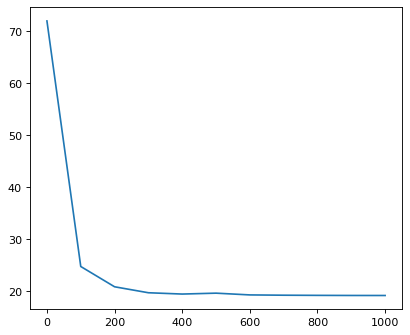

In [35]:
projections3, losses3 = obj3.nn_projection(n = 1000, plot_loss = True)

In [36]:
df_nn3 = obj3.nn_output(projections3)
df_nn3.head()

computing pair-wise distances...
manifold aligned # of pairs: 9000000
adding column 'rank'...
adding column 'correspondence_score'...


,idx,dist,rank,correspondence_score
PLA2G2A_CD74,"(2989, 2783)",0.000277,1,626.270984
DCN_CD74,"(2859, 2783)",0.000975,2,479.729454
TNC_CD74,"(2986, 2783)",0.001553,3,423.831926
APOD_CD74,"(2971, 2783)",0.002163,4,375.345769
PLA2G2A_CD63,"(2989, 685)",0.003406,5,284.615909


[[ 1.        -0.4408631]
 [-0.4408631  1.       ]]


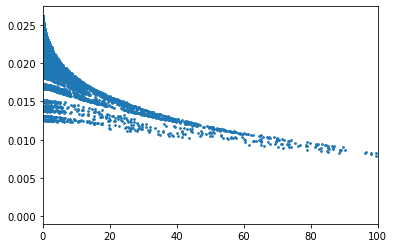

In [37]:
#check corr
select = df_nn3['correspondence_score'] != 0
nX = np.asarray(df_nn3['correspondence_score'][select])
nY = np.asarray(df_nn3['dist'][select])
r = np.corrcoef(nX, nY)
print(r)

plt.scatter(nX, nY, s=3)
plt.xlim(0, 100)
plt.show()

In [38]:
df_nn_filtered3 = obj3.filtered_nn_output(df_nn3, candidates)
df_nn_filtered3.head()

manifold aligned # of L-R pairs: 771


,idx,dist,rank,correspondence_score,rank_filtered
MIF_CD74,"(1672, 2783)",0.011013,225,41.658144,1
SERPINF1_PLXDC2,"(2719, 1687)",0.011412,267,52.017480,2
DCN_TLR2,"(2859, 2502)",0.011677,301,29.714563,3
CCL2_CXCR4,"(2900, 2822)",0.012394,427,39.435533,4
PLA2G2A_ITGA5,"(2989, 899)",0.012396,429,7.098730,5


In [39]:
df_enriched3 = obj3.chi2_test(df_nn3, df = 3, pval = 0.05, FDR = True, candidates = candidates)

df_enriched3


Total enriched: 0 / 9000000


,idx,dist,rank,correspondence_score,q_val,rank_filtered


In [40]:
df_nn_filtered3.loc['MIF_CD74']

idx                     (1672, 2783)
dist                        0.011013
rank                             225
correspondence_score       41.658144
rank_filtered                      1
Name: MIF_CD74, dtype: object